Analista Financiero Autónomo (Multiagente + Ollama + Yahoo Finance)

Este notebook implementa un prototipo de sistema multiagente que:
- Recibe consultas como: "Analiza las acciones de AAPL y NVDA esta semana".
- Consulta datos de mercado desde Yahoo Finance.
- Obtiene noticias relacionadas y realiza análisis de texto.
- Usa un modelo LLM (Ollama) para generar un informe en lenguaje natural.

Arquitectura: Coordinador + agentes especialistas (datos de mercado, noticias, NLP, LLM).

### 1 – Instalación de dependencias



In [3]:
# Librerías de datos y web
!pip install -q yfinance beautifulsoup4 requests lxml pandas matplotlib


# (Opcional) NLP más avanzado: modelos de sentimiento, NER, etc.
# Descomenta si luego los vas a usar.
!pip install -q spacy transformers textblob

In [4]:
# 1. Instalar Ollama (solo una vez por sesión)
!curl -fsSL https://ollama.com/install.sh | sh

import subprocess
import time

# 2. Levantar el servidor de Ollama en segundo plano
#   (subprocess.Popen evita que se "pegue" la celda)
_ = subprocess.Popen(["ollama", "serve"])
time.sleep(5)  # darle unos segundos para que arranque

# 3. (Opcional) Instalar el cliente de Python para Ollama
!pip install -q ollama

# 4. Descargar el modelo llama3 (esto sí puede tardar varios minutos)
print("Descargando el modelo llama3 (puede tardar)...")
!ollama pull llama3

# 5. Verificar que el modelo quedó instalado
print("\nModelos disponibles:")
!ollama list


>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Descargando el modelo llama3 (puede tardar)...


Modelos disponibles:
NAME             ID              SIZE      MODIFIED               
llama3:latest    365c0bd3c000    4.7 GB    Less than a second ago    


### 2 – Imports y configuración general

In [5]:
import re
import yfinance as yf
import requests
import pandas as pd
import datetime as dt
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
# Más adelante, si entrenamos algún modelo de ML clásico:
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB

# Descargar recursos básicos de NLTK (solo la primera vez en la sesión)
nltk.download("punkt")
nltk.download("stopwords")

# Configuración básica de pandas y matplotlib
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

plt.rcParams["figure.figsize"] = (10, 5)
plt.style.use("seaborn-v0_8")

# Fechas por defecto: última semana
HOY = dt.date.today()
DEFAULT_DAYS = 7

print("Imports listos. Fecha de hoy:", HOY)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Imports listos. Fecha de hoy: 2025-12-09


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 3 – Cliente LLM con Ollama

In [6]:
import ollama

def call_llm_ollama(
    prompt: str,
    model: str = "llama3",
    system_prompt: str | None = None,
    temperature: float = 0.2,
) -> str:
    """
    Llama al modelo de Ollama usando la API de Python.
    - prompt: instrucción / mensaje del usuario
    - model: nombre del modelo en Ollama (ej. 'llama3')
    - system_prompt: mensaje de sistema opcional para definir el rol
    """
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": prompt})

    try:
        response = ollama.chat(
            model=model,
            messages=messages,
            options={"temperature": temperature},
        )
        return response["message"]["content"]
    except Exception as e:
        print("⚠️ Error llamando al modelo de Ollama:", e)
        return "[ERROR] No se pudo obtener respuesta del LLM."

In [7]:
# Prueba rápida
test_answer = call_llm_ollama(
    "Respóndeme en una frase: ¿qué eres?",
    system_prompt="Eres un asistente breve y claro que responde en español."
)
print(test_answer)

Soy un asistente artificialmente inteligente diseñado para proporcionarte respuestas breves y claras a tus preguntas.


### 4 – Herramienta / Agente de datos de mercado (Yahoo Finance)

In [8]:
def get_market_data(tickers, days: int = DEFAULT_DAYS, interval: str = "1d"):
    """
    Obtiene datos de mercado recientes para una lista de tickers usando yfinance.

    Parámetros:
    - tickers: lista de símbolos (ej. ["AAPL", "NVDA"])
    - days: número de días hacia atrás desde hoy
    - interval: resolución (1d, 1h, 30m, etc.)

    Retorna:
    - data_dict: {ticker: DataFrame con OHLCV y retornos}
    - summary_df: DataFrame resumen con variación porcentual en el período
    """
    end = dt.date.today()
    start = end - dt.timedelta(days=days)

    data_dict = {}
    summary_rows = []

    for t in tickers:
        print(f"Descargando datos para {t} ({start} -> {end})...")
        df = yf.download(t, start=start, end=end, interval=interval, progress=False)

        if df.empty:
            print(f"⚠️ No se encontraron datos para {t}")
            continue

        # Asegurarnos de tener columna de cierre ajustado
        if "Adj Close" not in df.columns:
            df["Adj Close"] = df["Close"]

        # Retorno porcentual diario/simple
        df["Return"] = df["Adj Close"].pct_change()

        # 👉 AQUÍ ESTABA EL ERROR, VA ASÍ:
        data_dict[t] = df

        # Resumen simple por ticker
        precio_ini = df["Adj Close"].iloc[0]
        precio_fin = df["Adj Close"].iloc[-1]
        var_pct = (precio_fin / precio_ini - 1) * 100

        summary_rows.append({
            "ticker": t,
            "fecha_inicio": df.index[0].date(),
            "fecha_fin": df.index[-1].date(),
            "precio_inicio": float(precio_ini),
            "precio_fin": float(precio_fin),
            "variacion_pct": float(var_pct),
        })

    summary_df = pd.DataFrame(summary_rows)
    return data_dict, summary_df


def plot_prices(data_dict):
    """
    Grafica precios de cierre ajustado para cada ticker.
    """
    if not data_dict:
        print("⚠️ No hay datos para graficar.")
        return

    for ticker, df in data_dict.items():
        plt.plot(df.index, df["Adj Close"], label=ticker)
    plt.legend()
    plt.title("Precios de cierre ajustado")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.grid(True)
    plt.show()

Descargando datos para AAPL (2025-12-02 -> 2025-12-09)...


/tmp/ipython-input-2948255175.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, interval=interval, progress=False)


Descargando datos para NVDA (2025-12-02 -> 2025-12-09)...


/tmp/ipython-input-2948255175.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, interval=interval, progress=False)



Resumen de variación (últimos 7 días):


,ticker,fecha_inicio,fecha_fin,precio_inicio,precio_fin,variacion_pct
0,AAPL,2025-12-02,2025-12-08,286.19,277.89,-2.90
1,NVDA,2025-12-02,2025-12-08,181.45,185.55,2.26


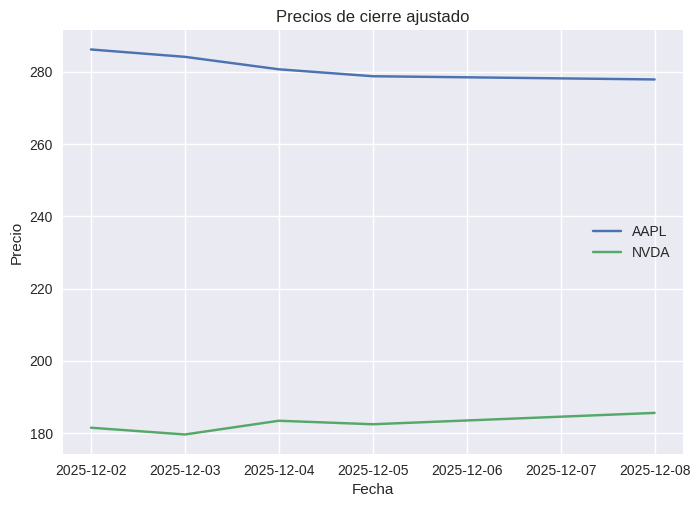

In [9]:
# Prueba rápida de la función
tickers_test = ["AAPL", "NVDA"]
data_test, summary_test = get_market_data(tickers_test, days=7)

print("\nResumen de variación (últimos 7 días):")
display(summary_test)

plot_prices(data_test)

### 5 – Herramienta / Agente de noticias (pseudo-scraping)

In [11]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (X11; Linux x86_64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "es-ES,es;q=0.9,en;q=0.8",
}

# Usamos el dominio de Yahoo Finanzas para LATAM
YAHOO_BASE_NEWS = "https://es-us.finanzas.yahoo.com"


def yahoo_news_url_for_ticker(ticker: str) -> str:
    """
    URL de noticias para un ticker en Yahoo Finanzas (es-US).
    Ej: https://es-us.finanzas.yahoo.com/quote/AAPL/news/
    """
    return f"{YAHOO_BASE_NEWS}/quote/{ticker}/news/"

spanish_stopwords = set(stopwords.words("spanish"))

def limpiar_texto_taller2(texto: str) -> str:
    """
    Limpia texto al estilo Taller 2:
      - minúsculas
      - quita símbolos
      - tokeniza
      - elimina stopwords en español y tokens muy cortos
    """
    texto = texto.lower()
    texto = re.sub(r"[^a-záéíóúñü0-9\s]", " ", texto)
    tokens = word_tokenize(texto, language="spanish")
    tokens = [t for t in tokens if t not in spanish_stopwords and len(t) > 2]
    return " ".join(tokens)


def get_news_for_ticker_from_yahoo(ticker: str, max_articles: int = 5):
    """
    Scraping de titulares de noticias para un ticker desde Yahoo Finanzas (es-US).
    Devuelve una lista de dicts:
      [{"ticker": ..., "titulo": ..., "url": ...}, ...]
    Siempre devuelve ALGO: si falla, usa noticias de ejemplo.
    """
    url = yahoo_news_url_for_ticker(ticker)
    print(f"Buscando noticias para {ticker} en {url}")

    articles = []

    try:
        resp = requests.get(url, headers=HEADERS, timeout=10)
        status = resp.status_code
        print(f"  -> status HTTP: {status}")

        if status == 200:
            soup = BeautifulSoup(resp.text, "lxml")

            # Buscar enlaces que tengan "/news/" en el href (titulares de noticias)
            for a in soup.find_all("a", href=True):
                href = a["href"]
                if "/news/" not in href:
                    continue

                title = a.get_text(strip=True)
                if not title:
                    continue

                # evitar duplicados por título
                if any(title == art["titulo"] for art in articles):
                    continue

                full_url = href if href.startswith("http") else f"{YAHOO_BASE_NEWS}{href}"

                articles.append({
                    "ticker": ticker,
                    "titulo": title,
                    "url": full_url,
                })

                if len(articles) >= max_articles:
                    break
        else:
            # no 200 → dejamos articles = []
            print(f"⚠️ Respuesta no 200 ({status}), se usará fallback.")
    except Exception as e:
        print(f"⚠️ Error al obtener noticias de {ticker}: {e}")
        # articles se queda como []

    # Fallback si no encontramos nada (404, cambios de HTML, bloqueo, etc.)
    if not articles:
        print(f"⚠️ No se pudieron extraer titulares reales para {ticker}. Usando noticias de ejemplo.")
        fake_news = [
            f"{ticker}: La compañía reporta resultados trimestrales mejor de lo esperado.",
            f"{ticker}: Analistas revisan sus perspectivas para la acción.",
            f"{ticker}: Noticias mixtas en el sector impactan el desempeño reciente.",
        ]
        articles = [
            {"ticker": ticker, "titulo": t, "url": None}
            for t in fake_news[:max_articles]
        ]

    return articles


def get_news_for_tickers(tickers, max_articles: int = 5, limpiar: bool = True):
    """
    Scraping para múltiples tickers + limpieza de texto.

    Retorna:
      {
        "AAPL": {
          "raw": [
            {"ticker": "AAPL", "titulo": "...", "url": "https://..."},
            ...
          ],
          "clean_titles": ["texto_limpio_1", "texto_limpio_2", ...]
        },
        ...
      }
    """
    news_dict = {}

    for t in tickers:
        articles = get_news_for_ticker_from_yahoo(t, max_articles=max_articles)

        if limpiar:
            clean_titles = [limpiar_texto_taller2(a["titulo"]) for a in articles]
        else:
            clean_titles = None

        news_dict[t] = {
            "raw": articles,
            "clean_titles": clean_titles,
        }

    return news_dict

In [15]:
# Prueba rápida
tickers_test = ["AAPL", "NVDA"]
news_test = get_news_for_tickers(tickers_test, max_articles=3, limpiar=True)

for t, info in news_test.items():
    print(f"\n=== Noticias para {t} (RAW) ===")
    for art in info["raw"]:
        print("-", art["titulo"], "|", art["url"])

    print(f"\n=== Titulares LIMPIOS para {t} ===")
    for txt in info["clean_titles"]:
        print("-", txt)

Buscando noticias para AAPL en https://es-us.finanzas.yahoo.com/quote/AAPL/news/
  -> status HTTP: 500
⚠️ Respuesta no 200 (500), se usará fallback.
⚠️ No se pudieron extraer titulares reales para AAPL. Usando noticias de ejemplo.
Buscando noticias para NVDA en https://es-us.finanzas.yahoo.com/quote/NVDA/news/
  -> status HTTP: 500
⚠️ Respuesta no 200 (500), se usará fallback.
⚠️ No se pudieron extraer titulares reales para NVDA. Usando noticias de ejemplo.

=== Noticias para AAPL (RAW) ===
- AAPL: La compañía reporta resultados trimestrales mejor de lo esperado. | None
- AAPL: Analistas revisan sus perspectivas para la acción. | None
- AAPL: Noticias mixtas en el sector impactan el desempeño reciente. | None

=== Titulares LIMPIOS para AAPL ===
- aapl compañía reporta resultados trimestrales mejor esperado
- aapl analistas revisan perspectivas acción
- aapl noticias mixtas sector impactan desempeño reciente

=== Noticias para NVDA (RAW) ===
- NVDA: La compañía reporta resultados trime

### 6 - Herramienta / Agente de NLP (Naive Bayes + TF-IDF)

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# 1. Dataset pequeñito de ejemplo (hecho a mano) para entrenar sentimiento
#    Puedes ampliarlo con más frases si quieres mejorar el modelo.
train_texts = [
    # POSITIVO
    "resultados trimestrales mejor de lo esperado",
    "ganancias récord impulsan la acción",
    "analistas suben precio objetivo",
    "mercado reacciona de forma positiva a la noticia",
    "ventas crecen por encima de las expectativas",
    "la compañía muestra un crecimiento sólido",
    "acciones suben tras buenos resultados",
    "pronóstico optimista para el próximo trimestre",
    "beneficios aumentan y sorprenden al mercado",
    "perspectivas favorables para la compañía",

    # NEGATIVO
    "resultados peor de lo esperado",
    "pérdidas mayores presionan a la acción",
    "analistas recortan precio objetivo",
    "mercado reacciona de forma negativa a la noticia",
    "ventas caen por debajo de las expectativas",
    "la compañía muestra un desempeño débil",
    "acciones caen tras malos resultados",
    "pronóstico pesimista para el próximo trimestre",
    "beneficios disminuyen y decepcionan al mercado",
    "incertidumbre y riesgo afectan la acción",

    # NEUTRAL
    "la compañía publica su informe anual",
    "no hay cambios relevantes en el pronóstico",
    "mercado espera resultados de la compañía",
    "analistas mantienen su recomendación",
    "acciones se mantienen estables",
    "noticia describe el contexto general del sector",
    "se anuncia una reunión con inversionistas",
    "mercado permanece atento a nuevos datos",
    "no se registran movimientos significativos",
    "comentarios mixtos sobre la compañía",
]

train_labels = [
    # 10 positivos
    "pos","pos","pos","pos","pos",
    "pos","pos","pos","pos","pos",
    # 10 negativos
    "neg","neg","neg","neg","neg",
    "neg","neg","neg","neg","neg",
    # 10 neutros
    "neu","neu","neu","neu","neu",
    "neu","neu","neu","neu","neu",
]

# 2. Creamos un pipeline TF-IDF + Naive Bayes
sentiment_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=2000,
        ngram_range=(1, 2),
    )),
    ("nb", MultinomialNB()),
])

# 3. Entrenamos el modelo
sentiment_clf.fit(train_texts, train_labels)

def nb_sentiment(text: str) -> str:
    """
    Clasifica un texto limpio como pos/neg/neu usando Naive Bayes.
    Devuelve 'positivo', 'negativo' o 'neutral'.
    """
    if not text or not text.strip():
        return "neutral"

    label = sentiment_clf.predict([text])[0]
    if label == "pos":
        return "positivo"
    elif label == "neg":
        return "negativo"
    else:
        return "neutral"


def analyze_news_sentiment_nb(news_dict):
    """
    news_dict:
      {
        "AAPL": {
          "raw": [...],
          "clean_titles": ["texto_limpio_1", "texto_limpio_2", ...]
        },
        ...
      }

    Devuelve:
      {
        "AAPL": {
          "sentiments": ["positivo", "neutral", ...],
          "sentiment_global": "positivo" / "negativo" / "neutral" / "sin_datos",
          "num_pos": X,
          "num_neg": Y,
          "num_neu": Z
        },
        ...
      }
    """
    result = {}

    for ticker, info in news_dict.items():
        clean_titles = info.get("clean_titles") or []

        if not clean_titles:
            result[ticker] = {
                "sentiments": [],
                "sentiment_global": "sin_datos",
                "num_pos": 0,
                "num_neg": 0,
                "num_neu": 0,
            }
            continue

        sentiments = [nb_sentiment(txt) for txt in clean_titles]

        pos = sentiments.count("positivo")
        neg = sentiments.count("negativo")
        neu = sentiments.count("neutral")

        # Regla simple para sentimiento global
        if pos > neg and pos >= neu:
            global_sent = "positivo"
        elif neg > pos and neg >= neu:
            global_sent = "negativo"
        else:
            global_sent = "neutral"

        result[ticker] = {
            "sentiments": sentiments,
            "sentiment_global": global_sent,
            "num_pos": pos,
            "num_neg": neg,
            "num_neu": neu,
        }

    return result

In [17]:
# 4. Prueba rápida usando el agente de noticias
tickers_test = ["AAPL", "NVDA"]
news_test = get_news_for_tickers(tickers_test, max_articles=3, limpiar=True)
sentiments_test = analyze_news_sentiment_nb(news_test)

print("\n=== Sentimiento por ticker (Naive Bayes) ===")
for t, s in sentiments_test.items():
    print(f"{t}: {s}")

Buscando noticias para AAPL en https://es-us.finanzas.yahoo.com/quote/AAPL/news/
  -> status HTTP: 500
⚠️ Respuesta no 200 (500), se usará fallback.
⚠️ No se pudieron extraer titulares reales para AAPL. Usando noticias de ejemplo.
Buscando noticias para NVDA en https://es-us.finanzas.yahoo.com/quote/NVDA/news/
  -> status HTTP: 500
⚠️ Respuesta no 200 (500), se usará fallback.
⚠️ No se pudieron extraer titulares reales para NVDA. Usando noticias de ejemplo.

=== Sentimiento por ticker (Naive Bayes) ===
AAPL: {'sentiments': ['positivo', 'positivo', 'negativo'], 'sentiment_global': 'positivo', 'num_pos': 2, 'num_neg': 1, 'num_neu': 0}
NVDA: {'sentiments': ['positivo', 'positivo', 'negativo'], 'sentiment_global': 'positivo', 'num_pos': 2, 'num_neg': 1, 'num_neu': 0}


### 7 – Clases de agentes (Market, WebNews, NLP, LLM, Coordinator)

In [34]:
# ============================
# Celda 7 - Definición de agentes (con memoria)
# ============================

class MarketDataAgent:
    """
    Agente especializado en obtener y resumir datos de mercado desde Yahoo Finance.
    """
    def __init__(self, days: int = DEFAULT_DAYS, interval: str = "1d"):
        self.days = days
        self.interval = interval

    def run(self, tickers):
        data_dict, summary_df = get_market_data(
            tickers,
            days=self.days,
            interval=self.interval
        )
        return {
            "raw_data": data_dict,
            "summary": summary_df,
        }


class WebNewsAgent:
    """
    Agente de adquisición web: obtiene titulares (reales o fallback) y los limpia.
    Cumple el requisito de 'Adquisición (Web)'.
    """
    def __init__(self, max_articles: int = 5, limpiar: bool = True):
        self.max_articles = max_articles
        self.limpiar = limpiar

    def run(self, tickers):
        news_dict = get_news_for_tickers(
            tickers,
            max_articles=self.max_articles,
            limpiar=self.limpiar,
        )
        return news_dict


class NLPAgent:
    """
    Agente de análisis de texto: usa TF-IDF + Naive Bayes para sentimiento.
    """
    def __init__(self):
        # El modelo sentiment_clf ya está entrenado en la Celda 6
        pass

    def run(self, news_dict):
        sentiments = analyze_news_sentiment_nb(news_dict)
        return sentiments


class LLMAnalystAgent:
    """
    Agente analista: construye el prompt y llama al LLM (Ollama).
    """
    def __init__(self, model_name: str = "llama3"):
        self.model_name = model_name
        self.system_prompt = (
            "Eres un analista financiero educativo. "
            "Analizas acciones usando datos de mercado recientes y noticias. "
            "Siempre aclaras que tu recomendación es simulada y solo con fines académicos, "
            "no es asesoría financiera real."
        )

    def build_prompt(self, user_query: str,
                     market_summary: pd.DataFrame,
                     news_dict,
                     sentiments_dict) -> str:
        prompt = ""
        prompt += f"Consulta del usuario: {user_query}\n\n"

        prompt += "=== Resumen de datos de mercado (últimos días) ===\n"
        if market_summary is not None and not market_summary.empty:
            prompt += market_summary.to_string(index=False)
        else:
            prompt += "No se encontraron datos de mercado.\n"
        prompt += "\n\n"

        prompt += "=== Resumen de noticias y sentimiento por ticker ===\n"
        for ticker, info in sentiments_dict.items():
            sent_global = info.get("sentiment_global", "sin_datos")
            num_pos = info.get("num_pos", 0)
            num_neg = info.get("num_neg", 0)
            num_neu = info.get("num_neu", 0)

            prompt += f"- {ticker}: sentimiento global = {sent_global} "
            prompt += f"(+:{num_pos}, -:{num_neg}, neutro:{num_neu})\n"

            news_info = news_dict.get(ticker, {})
            raw_articles = news_info.get("raw", [])[:3]
            if raw_articles:
                prompt += "  Titulares recientes:\n"
                for art in raw_articles:
                    prompt += f"    • {art['titulo']}\n"
            prompt += "\n"

        prompt += (
            "Con base en estos datos de mercado y en el contexto de las noticias, "
            "realiza un análisis comparativo de cada activo. Explica:\n"
            "- Cómo se han comportado en el período analizado.\n"
            "- Qué factores (noticias, sector, resultados) podrían explicar este comportamiento.\n"
            "- Una recomendación simulada de inversión (comprar / mantener / vender) para cada uno,\n"
            "  con justificación clara, recordando que esto es solo un ejercicio educativo "
            "y no asesoría financiera real.\n"
        )

        return prompt

    def run(self, user_query: str,
            market_summary: pd.DataFrame,
            news_dict,
            sentiments_dict) -> str:
        prompt = self.build_prompt(
            user_query,
            market_summary,
            news_dict,
            sentiments_dict
        )
        answer = call_llm_ollama(
            prompt,
            model=self.model_name,
            system_prompt=self.system_prompt,
            temperature=0.2,
        )
        return answer


class CoordinatorAgent:
    """
    Agente coordinador: orquesta todo el flujo multiagente,
    extrae tickers de la consulta en lenguaje natural y
    mantiene memoria básica de las interacciones.
    """
    def __init__(self,
                 days: int = DEFAULT_DAYS,
                 interval: str = "1d",
                 max_articles: int = 5,
                 llm_model_name: str = "llama3"):
        self.market_agent = MarketDataAgent(days=days, interval=interval)
        self.web_agent = WebNewsAgent(max_articles=max_articles, limpiar=True)
        self.nlp_agent = NLPAgent()
        self.llm_agent = LLMAnalystAgent(model_name=llm_model_name)
        self.history = []

    def run(self, user_query: str, tickers=None):
        # 0. Si no nos pasan tickers, los sacamos del user_query
        if tickers is None:
            tickers = extract_tickers_from_query(user_query)

        if not tickers:
            raise ValueError(
                "No se detectaron tickers en la consulta. "
                "Incluye símbolos como AAPL, NVDA, EC, TSLA, etc."
            )

        # 1. Datos de mercado
        market_result = self.market_agent.run(tickers)
        market_summary = market_result["summary"]
        raw_market_data = market_result["raw_data"]

        # 2. Noticias
        news_dict = self.web_agent.run(tickers)

        # 3. Sentimiento
        sentiments_dict = self.nlp_agent.run(news_dict)

        # 4. LLM
        llm_answer = self.llm_agent.run(
            user_query=user_query,
            market_summary=market_summary,
            news_dict=news_dict,
            sentiments_dict=sentiments_dict,
        )

        # 5. Guardar en memoria
        self.history.append({
            "user_query": user_query,
            "tickers": list(tickers),
            "market_summary": market_summary.copy(),
            "sentiments": sentiments_dict,
            "llm_answer": llm_answer,
        })

        return {
            "market_summary": market_summary,
            "market_raw": raw_market_data,
            "news": news_dict,
            "sentiments": sentiments_dict,
            "llm_answer": llm_answer,
            "history_len": len(self.history),
        }


In [35]:
import re

def extract_tickers_from_query(user_query: str, max_len: int = 5):
    """
    Extrae posibles tickers de bolsa de una consulta en lenguaje natural.
    Regla simple:
      - palabras en MAYÚSCULAS
      - de 1 a max_len letras (AAPL, NVDA, MSFT, TSLA, etc.)
    """
    # Encontrar palabras en mayúsculas
    candidates = re.findall(r"\b[A-Z]{1," + str(max_len) + r"}\b", user_query)
    # Eliminar duplicados preservando orden
    seen = set()
    tickers = []
    for c in candidates:
        if c not in seen:
            seen.add(c)
            tickers.append(c)
    return tickers


# Prueba rápida
q_test = "Analiza las acciones de AAPL y NVDA esta semana y compáralas con MSFT."
print("Consulta:", q_test)
print("Tickers detectados:", extract_tickers_from_query(q_test))


Consulta: Analiza las acciones de AAPL y NVDA esta semana y compáralas con MSFT.
Tickers detectados: ['AAPL', 'NVDA', 'MSFT']


Historial de preguntas

In [28]:
#prueba rapida
len(coordinator.history)
coordinator.history[-1]["user_query"]
coordinator.history[-1]["llm_answer"][:500]

'**Análisis comparativo de AAPL y NVDA**\n\n**AAPL:**\n\nEn el período analizado (2025-12-02 a 2025-12-08), la acción de AAPL ha experimentado una variación del -2.90%, lo que indica un descenso en su valor. Aunque no es un cambio significativo, es importante considerar las noticias y sentimiento global asociados con esta acción.\n\nEl sentimiento global es positivo, lo que sugiere que la mayoría de los analistas y inversores tienen una visión optimista sobre la empresa. Las noticias recientes han sido'

### 8 - Demo end-to-end del sistema multiagente

Descargando datos para AAPL (2025-12-02 -> 2025-12-09)...
Descargando datos para NVDA (2025-12-02 -> 2025-12-09)...
Buscando noticias para AAPL en https://es-us.finanzas.yahoo.com/quote/AAPL/news/


/tmp/ipython-input-2948255175.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, interval=interval, progress=False)
/tmp/ipython-input-2948255175.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, interval=interval, progress=False)


  -> status HTTP: 500
⚠️ Respuesta no 200 (500), se usará fallback.
⚠️ No se pudieron extraer titulares reales para AAPL. Usando noticias de ejemplo.
Buscando noticias para NVDA en https://es-us.finanzas.yahoo.com/quote/NVDA/news/
  -> status HTTP: 500
⚠️ Respuesta no 200 (500), se usará fallback.
⚠️ No se pudieron extraer titulares reales para NVDA. Usando noticias de ejemplo.
=== Resumen de mercado (últimos 7 días) ===


,ticker,fecha_inicio,fecha_fin,precio_inicio,precio_fin,variacion_pct
0,AAPL,2025-12-02,2025-12-08,286.19,277.89,-2.90
1,NVDA,2025-12-02,2025-12-08,181.45,185.55,2.26



=== Sentimiento por ticker (Naive Bayes) ===
AAPL: {'sentiments': ['positivo', 'positivo', 'negativo'], 'sentiment_global': 'positivo', 'num_pos': 2, 'num_neg': 1, 'num_neu': 0}
NVDA: {'sentiments': ['positivo', 'positivo', 'negativo'], 'sentiment_global': 'positivo', 'num_pos': 2, 'num_neg': 1, 'num_neu': 0}

=== Gráfico de precios ===


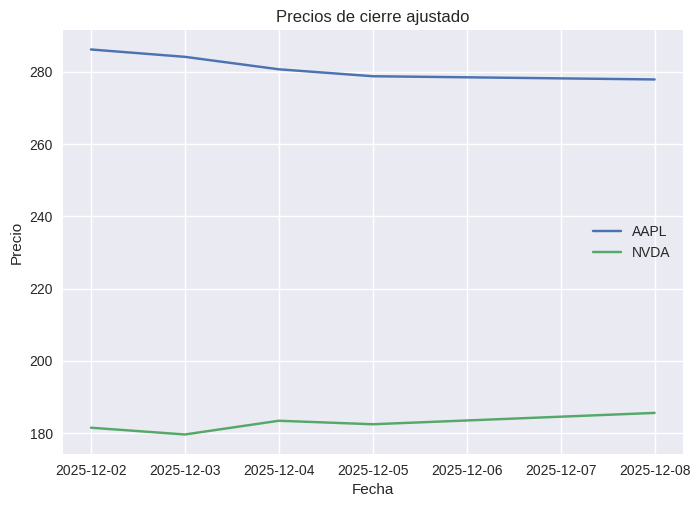


=== Noticias para AAPL (RAW) ===
- AAPL: La compañía reporta resultados trimestrales mejor de lo esperado.
- AAPL: Analistas revisan sus perspectivas para la acción.
- AAPL: Noticias mixtas en el sector impactan el desempeño reciente.

=== Noticias para NVDA (RAW) ===
- NVDA: La compañía reporta resultados trimestrales mejor de lo esperado.
- NVDA: Analistas revisan sus perspectivas para la acción.
- NVDA: Noticias mixtas en el sector impactan el desempeño reciente.

=== Informe del Analista Financiero Autónomo (LLM/Ollama) ===

**Análisis Comparativo de AAPL y NVDA**

**AAPL:**

En el período analizado (2025-12-02 a 2025-12-08), la acción de AAPL ha experimentado una variación del -2.90% en términos de precio, lo que indica un declive en su valor.

El sentimiento global sobre la acción es positivo, con dos noticias positivas y solo una negativa. Las noticias recientes incluyen el reporte de resultados trimestrales mejor de lo esperado, lo que podría haber impulsado inicialmente el pr

In [37]:
user_query = "Analiza las acciones de AAPL y NVDA esta semana"

coordinator = CoordinatorAgent(
    days=7,
    interval="1d",
    max_articles=3,
    llm_model_name="llama3",
)

result = coordinator.run(user_query)

# 1. Mostrar resumen de mercado
print("=== Resumen de mercado (últimos 7 días) ===")
display(result["market_summary"])

# 2. Mostrar sentimiento por ticker
print("\n=== Sentimiento por ticker (Naive Bayes) ===")
for t, s in result["sentiments"].items():
    print(f"{t}: {s}")

# 3. Graficar precios
print("\n=== Gráfico de precios ===")
plot_prices(result["market_raw"])

# 4. Mostrar algunas noticias (raw)
for t, info in result["news"].items():
    print(f"\n=== Noticias para {t} (RAW) ===")
    for art in info["raw"]:
        print("-", art["titulo"])

# 5. Informe final del analista (LLM/Ollama)
print("\n=== Informe del Analista Financiero Autónomo (LLM/Ollama) ===\n")
print(result["llm_answer"])
